# Convert Tactus xml files to csv files

In [1]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import xml.etree.ElementTree as ET

In [2]:
CLIENT = "client"
COUNSELOR = "counselor"
DATADIR = "../usb/tmp/20190917/"
FILEPATTERN = "AdB.*xml.gz"

## Process tag AssignedCounselor

In [3]:
TACTUSMAIL = "alcoholdebaas@tactus.nl"
EMAIL = "Email"

def dictToString(data):
    string = ""
    for key in sorted(data.keys()):
        string += key+":"+data[key]+" "
    return(string)

def inExcludedCounselors(counselorString):
    return(not re.search(EMAIL+":",counselorString,flags=re.IGNORECASE) or \
           re.search(TACTUSMAIL,counselorString,flags=re.IGNORECASE))

def fileNameToId(fileName):
    return(fileName.split(".")[0])

def readGzippedXmlFile(inFileName):
    inFile = gzip.open(inFileName)
    inFileContent = inFile.read()
    inFile.close()
    root = ET.fromstring(inFileContent)
    return(root)

In [4]:
COUNSELORQUERY = "./AssignedCounselor"
OUTFILENAME = "AssignedCounselor.csv"

def getCounselorData():
    inFileNames = sorted(os.listdir(DATADIR))
    clientDict = {}
    counselorDict = {"":0}
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for counselor in root.findall(COUNSELORQUERY):
                counselorData = {}
                for i in range(0,len(counselor)):
                    try:
                        counselorData[counselor[i].tag.strip()] = counselor[i].text.strip()
                    except: pass
            counselorString = dictToString(counselorData)
            if not counselorString in counselorDict: counselorDict[counselorString] = len(counselorDict)
            clientDict[fileNameToId(inFileName)] = counselorDict[counselorString]
    return(clientDict,counselorDict)

In [5]:
PLOTFILENAME = "AssignedCounselor.png"

def clientDictToCounselorDf(clientDict):
    counselorDf = pd.DataFrame(clientDict,index=[0]).T.rename(columns={0:COUNSELOR})
    counselorDf.index.name = CLIENT
    return(counselorDf)

def saveCounselorDf(counselorDf,outFileName=OUTFILENAME):
    counselorDf.to_csv(outFileName)
    
def visualizeCounselorDf(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    counselorDictT = {counselorDict[c]:c for c in counselorDict}
    x = [c for c in sorted(counselorGroups.keys()) if not inExcludedCounselors(counselorDictT[c])]
    y = [len(counselorGroups[g]) for g in x]
    plt.figure(figsize=(10,5))
    plt.bar(x,y)
    plt.xlabel("counselor id")
    plt.title(f"Number of clients per counselor (average: {round(np.average(y),1)}; standard deviation: {round(np.std(y))})")
    plt.savefig(PLOTFILENAME)
    plt.show()
    
def showExcludedCounselors(counselorDf,counselorDict):
    counselorGroups = counselorDf.groupby(COUNSELOR).groups
    for c in counselorDict:
        if inExcludedCounselors(c):
            print(f"id: {counselorDict[c]}; frequency: {len(counselorGroups[counselorDict[c]])}; data: {c}")
    

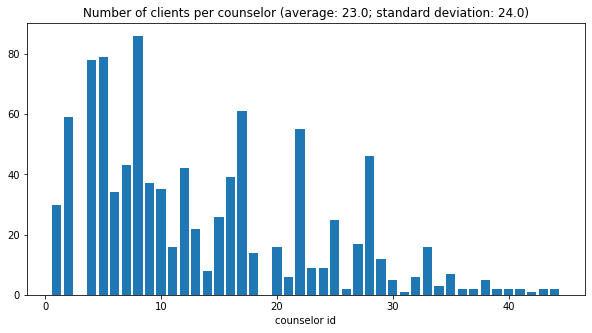

In [6]:
clientDict,counselorDict = getCounselorData()
counselorDf = clientDictToCounselorDf(clientDict)
saveCounselorDf(counselorDf,outFileName=OUTFILENAME)
visualizeCounselorDf(counselorDf,counselorDict)

In [7]:
showExcludedCounselors(counselorDf,counselorDict)

id: 0; frequency: 763; data: 
id: 3; frequency: 254; data: Email:alcoholdebaas@tactus.nl FirstName:Geen LastName:Hulpverlener 
id: 19; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Aangehouden LastName:cliënten 
id: 45; frequency: 1; data: Email:alcoholdebaas@tactus.nl FirstName:Niet LastName:Gestart 


## Process tag Intake

In [6]:
TITLE = "title"
QUESTIONNUMBER = "questionNumber"
ANSWER = "answer"
ANSWERID = "answerId"
ANSWERTEXT = "answerText"
ANSWERTITLE = "answerTitle"
ID = "ID"
QUERYINTAKE = "./Intake"
QUERYQUESTION = ".//question"
QUERYTITLE = "./"+TITLE
QUERYQUESTIONNUMBER = "./"+QUESTIONNUMBER
QUERYANSWER = "./"+ANSWER
QUERYANSWERTEXT = "./"+ANSWERTEXT
OUTFILENAME = "Intake.csv"
PLOTFILENAME = "Intake.png"
TITLESTRING = "Number of questions per client in intake forms"

In [7]:
def getAnswerDataList(querySection=QUERYINTAKE):
    inFileNames = sorted(os.listdir(DATADIR))
    answerDataList = []
    for inFileName in inFileNames:
        if re.search(FILEPATTERN,inFileName):
            root = readGzippedXmlFile(DATADIR+inFileName)
            for section in root.findall(querySection):
                for question in section.findall(QUERYQUESTION):
                    answerDict = {CLIENT:fileNameToId(inFileName)}
                    try:
                        answerDict[TITLE] = list(question.findall(QUERYTITLE))[0].text.strip()
                    except: pass
                    try:
                        answerDict[QUESTIONNUMBER] = list(question.findall(QUERYQUESTIONNUMBER))[0].text.strip()
                    except: pass
                    for answer in question.findall(QUERYANSWER):
                        answerDictCopy = dict(answerDict)
                        answerDictCopy[ANSWERID] = answer.attrib[ID]
                        try:
                            answerDictCopy[ANSWERTEXT] = list(answer.findall(QUERYANSWERTEXT))[0].text.strip()
                        except: pass
                        try:
                            answerDictCopy[ANSWERTITLE] = list(answer.findall(QUERYTITLE))[0].text.strip()
                        except: pass
                        answerDataList.append(answerDictCopy)
    return(answerDataList)

In [8]:
DATAFREQUENCYTHRESHOLD = 5
REMOVED = "REMOVED"

def makeAnswerId(answer):
    if not QUESTIONNUMBER in answer: questionNumber = ""
    else: questionNumber = answer[QUESTIONNUMBER]
    if not ANSWERID in answer: answerId = ""
    else: answerId = answer[ANSWERID]
    return(questionNumber+"-"+answerId)

def countAnswerTexts(answerDataList):
    answerTextFreqs = {}
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        try:
            answerText = answerDataList[i][ANSWERTEXT]
        except: answerText = ""
        if not answerId in answerTextFreqs: answerTextFreqs[answerId] = {}
        if not answerText in answerTextFreqs[answerId]: answerTextFreqs[answerId][answerText] = 0
        answerTextFreqs[answerId][answerText] += 1
    return(answerTextFreqs)

def removeRareDataValues(answerDataList,answerFreqs):
    for i in range(0,len(answerDataList)):
        answerId = makeAnswerId(answerDataList[i])
        if ANSWERTEXT in answerDataList[i] and \
           answerDataList[i][ANSWERTEXT] != "" and \
           answerFreqs[answerId][answerDataList[i][ANSWERTEXT]] < DATAFREQUENCYTHRESHOLD:
            answerDataList[i][ANSWERTEXT] = REMOVED
    return(answerDataList)

In [9]:
def answerDataListToDf(answerDataList):
    return(pd.DataFrame(answerDataList))

def saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME):
    answerDataDf.to_csv(outFileName,index=None)

In [10]:
def visualizeAnswerDataDf(answerDataDf,titleString=TITLESTRING,plotFileName=PLOTFILENAME):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    plt.figure(figsize=(16,5))
    plt.bar(x,y)
    plt.title(titleString)
    plt.xlabel("client id")
    plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    plt.savefig(plotFileName)
    plt.show()

In [11]:
def showValueFrequencies(answerDataDf):
    x = sorted(set(answerDataDf[CLIENT]))
    answerDataDfGroups = answerDataDf.groupby([CLIENT])
    y = [len(answerDataDfGroups.groups[client]) for client in x]
    yCounts = {yValue:y.count(yValue) for yValue in y}
    yCountsSorted = {yValue:yCounts[yValue] for yValue in sorted(yCounts.keys(),key=lambda yValue:yCounts[yValue],reverse=True)}
    print(yCountsSorted)

In [14]:
answerDataList = getAnswerDataList()
answerTextFreqs = countAnswerTexts(answerDataList)
answerDataList = removeRareDataValues(answerDataList,answerTextFreqs)
answerDataDf = answerDataListToDf(answerDataList)
saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME)

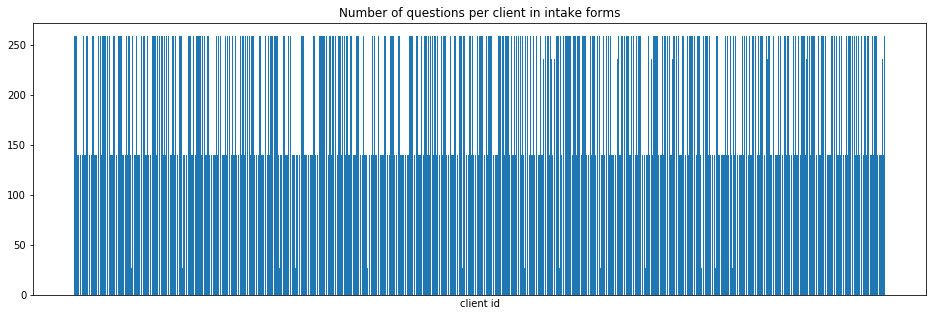

In [15]:
visualizeAnswerDataDf(answerDataDf)

In [16]:
showValueFrequencies(answerDataDf)

{259: 1014, 140: 881, 27: 46, 236: 42}


## Process tag Treatment

In [17]:
QUERYTREATMENT = "./Treatment"
OUTFILENAME = "Treatment.csv"
TITLESTRING = "Number of questions per client in treatment steps"
PLOTFILENAME = "Treatment.png"

answerDataList = getAnswerDataList(querySection=QUERYTREATMENT)
answerTextFreqs = countAnswerTexts(answerDataList)
answerDataList = removeRareDataValues(answerDataList,answerTextFreqs)
answerDataDf = answerDataListToDf(answerDataList)
saveAnswerDataDf(answerDataDf,outFileName=OUTFILENAME)

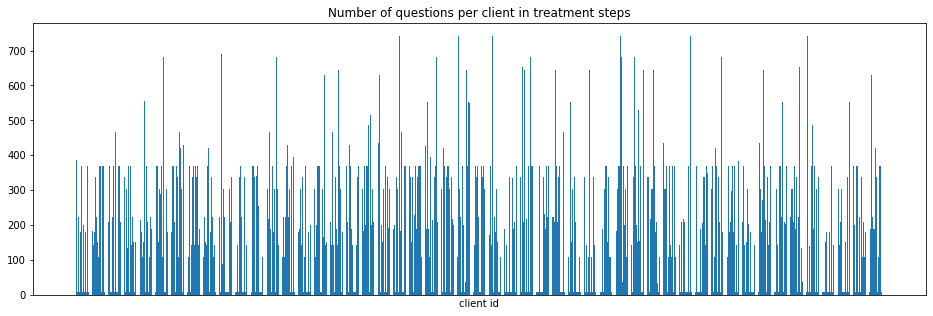

In [18]:
visualizeAnswerDataDf(answerDataDf,titleString=TITLESTRING,plotFileName=PLOTFILENAME)

In [19]:
showValueFrequencies(answerDataDf)

{8: 174, 369: 141, 9: 76, 304: 56, 337: 55, 108: 45, 142: 41, 210: 39, 224: 27, 179: 26, 189: 26, 151: 20, 199: 19, 682: 9, 645: 8, 467: 7, 742: 7, 217: 6, 422: 5, 552: 5, 182: 4, 223: 3, 429: 3, 631: 3, 434: 3, 37: 3, 135: 2, 214: 2, 297: 2, 428: 2, 689: 2, 394: 2, 488: 2, 192: 2, 228: 2, 172: 2, 654: 2, 530: 2, 203: 2, 387: 1, 279: 1, 556: 1, 290: 1, 663: 1, 559: 1, 88: 1, 340: 1, 254: 1, 165: 1, 516: 1, 427: 1, 213: 1, 550: 1, 29: 1, 335: 1, 233: 1, 154: 1, 35: 1, 205: 1, 349: 1, 268: 1, 384: 1, 272: 1, 139: 1, 144: 1}


In [20]:
inFileNames = sorted(os.listdir(DATADIR))
tags= {}
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        for section in root.findall(QUERYTREATMENT):
            for tag in section.findall(".//*"):
                if not tag.tag in tags: tags[tag.tag] = 0
                tags[tag.tag] += 1
{tag:tags[tag] for tag in sorted(tags.keys(),key=lambda t:tags[t],reverse=True)}

{'answer': 179958,
 'answerText': 179958,
 'title': 108423,
 'question': 65265,
 'questionNumber': 62285,
 'Title': 12180,
 'TreatmentStep': 6821,
 'SubmissionDate': 6821,
 'ApprovalDate': 6821,
 'ApprovingCounselor': 6821,
 'FirstName': 6154,
 'LastName': 6154,
 'Questionnaire': 5375,
 'Type': 5375,
 'Content': 5375,
 'Status': 1983,
 'StartDate': 1983,
 'EndDate': 1983,
 'TreatmentSteps': 1983}

In [21]:
len(answerDataList)

179958

In [17]:
import sys

QUERYTREATMENTSTEP = "./TreatmentSteps/TreatmentStep"
QUERYTITLE = "./Title"
QUERYANSWER = ".//"+ANSWER

def cleanupText(text):
    return(text.strip())

Most common treatment step order:

1. Voordelen, nadelen
2. Alcoholschrift bijhouden
3. Situaties analyseren
4. Meten en weten
5. Doel stellen
6. Gewoontes doorbreken
7. Anders denken
8. Anders doen
9. Beslissingen
10. Actieplan
11. Afsluiting
12. Na 3 maanden
13. Na half jaar
14. Na 9 maanden

In [22]:
inFileNames = sorted(os.listdir(DATADIR))
titles= {}
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        questionCount = 0
        for section in root.findall(QUERYTREATMENT):
            questionCountAll = len(section.findall(QUERYANSWER))
            for treatmentStep in section.findall(QUERYTREATMENTSTEP):
                questionCount += len(treatmentStep.findall(QUERYANSWER))
                for title in treatmentStep.findall(QUERYTITLE):
                    titleText = cleanupText(title.text)+" "+str(questionCountAll)+" "+str(questionCount)
                    if not titleText in titles: titles[titleText] = 0
                    titles[titleText] += 1
{titleText:titles[titleText] for titleText in sorted(titles.keys(),key=lambda t:titles[t],reverse=True)}

{'Voordelen, nadelen 8 8': 174,
 'Alcoholschrift bijhouden 8 8': 148,
 'Voordelen, nadelen 0 0': 147,
 'Voordelen, nadelen 369 8': 141,
 'Alcoholschrift bijhouden 369 8': 141,
 'Situaties analyseren 369 108': 141,
 'Meten en weten 369 142': 141,
 'Doel stellen 369 151': 141,
 'Gewoontes doorbreken 369 179': 141,
 'Anders denken 369 189': 141,
 'Anders doen 369 199': 141,
 'Beslissingen 369 210': 141,
 'Actieplan 369 224': 141,
 'Afsluiting 369 304': 141,
 'Na 3 maanden 369 337': 141,
 'Na half jaar 369 369': 141,
 'Doel stellen 9 9': 76,
 'Doel stellen 0 0': 67,
 'Voordelen, nadelen 304 8': 56,
 'Alcoholschrift bijhouden 304 8': 56,
 'Situaties analyseren 304 108': 56,
 'Meten en weten 304 142': 56,
 'Doel stellen 304 151': 56,
 'Gewoontes doorbreken 304 179': 56,
 'Anders denken 304 189': 56,
 'Anders doen 304 199': 56,
 'Beslissingen 304 210': 56,
 'Actieplan 304 224': 56,
 'Afsluiting 304 304': 56,
 'Voordelen, nadelen 337 8': 55,
 'Alcoholschrift bijhouden 337 8': 55,
 'Situaties a

## Process tag Diary

In [13]:
QUERYDIARY = "./Diary"
QUERYDIARYENTRY = "./DiaryEntries/DiaryEntry"

In [30]:
def findAllTexts(tag,prefix=""):
    textDict = {}
    for child in tag.findall("./*"):
        if child.text != None:
            childText = cleanupText(child.text)
            if childText != "":
                textDict[prefix+child.tag] = childText
        textDict.update(findAllTexts(child,prefix=prefix+child.tag))
    return(textDict)

In [49]:
inFileName = "AdB0001.xml.gz"

dataList = []
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        for section in root.findall(QUERYDIARY):
            for diaryEntry in section.findall(QUERYDIARYENTRY):
                diaryEntryDict = findAllTexts(diaryEntry)
                diaryEntryDict.update({CLIENT:fileNameToId(inFileName)})
                dataList.append(diaryEntryDict)

In [52]:
MINIMALDUPLICATEVALUES = 5
REMOVED = "REMOVED"
FIELDSTOKEEPLIST = "Date Time Urge Quantity StandardUnits client".split()

def countValues(listOfDict):
    countsDict = {}
    for i in range(0,len(listOfDict)):
        for dictKey in listOfDict[i].keys():
            valueKey = dictKey+" "+listOfDict[i][dictKey]
            if not valueKey in countsDict: countsDict[valueKey] = 0
            countsDict[valueKey] += 1
    return(countsDict)

def anonymize(listOfDict,countsDict,minimalDuplicateValues=MINIMALDUPLICATEVALUES):
    for i in range(0,len(listOfDict)):
        for dictKey in listOfDict[i].keys():
            valueKey = dictKey+" "+listOfDict[i][dictKey]
            if not dictKey in FIELDSTOKEEPLIST and countsDict[valueKey] < minimalDuplicateValues:
                listOfDict[i][dictKey] = REMOVED
    return(listOfDict)

In [54]:
countsDict = countValues(dataList)
dataListAnonymized = anonymize(dataList,countsDict)

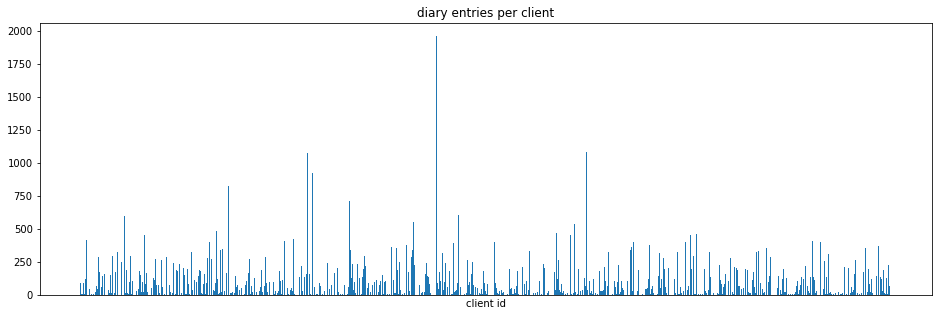

In [66]:
PLOTFILENAME = "Diary.png"

groups = pd.DataFrame(dataListAnonymized).groupby(CLIENT).groups
x = groups.keys()
y = [len(groups[client]) for client in x]
plt.figure(figsize=(16,5))
plt.bar(x,y)
plt.title("diary entries per client")
plt.xlabel("client id")
plt.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
plt.savefig(PLOTFILENAME)
plt.show()

In [56]:
QUERYDIARY = "./Diary"

inFileNames = sorted(os.listdir(DATADIR))
tags= {}
for inFileName in inFileNames:
    if re.search(FILEPATTERN,inFileName):
        root = readGzippedXmlFile(DATADIR+inFileName)
        for section in root.findall(QUERYDIARY):
            for tag in section.findall(".//*"):
                if not tag.tag in tags: tags[tag.tag] = 0
                tags[tag.tag] += 1
{tag:tags[tag] for tag in sorted(tags.keys(),key=lambda t:tags[t],reverse=True)}

{'DiaryEntry': 122330,
 'Date': 122330,
 'Time': 122330,
 'Urge': 122330,
 'StandardUnits': 122330,
 'Quantity': 82118,
 'MeasurementUnitName': 72465,
 'Snapshot': 18090,
 'Situation': 18090,
 'Location': 18090,
 'Companion': 18090,
 'Activity': 18090,
 'Occasion': 18090,
 'Thoughts': 18090,
 'Feeling': 18090,
 'Type': 18090,
 'Emotion': 18090,
 'Description': 18090,
 'Behavior': 18090,
 'BehaviorDetails': 18090,
 'DayTarget': 9653,
 'dayOfWeek': 9653,
 'DiaryEntries': 1983,
 'Targets': 1983,
 'DateLastOpenedByClient': 1983,
 'Target': 1379,
 'StartDate': 1379,
 'WeekTargetQuantity': 1379}

## Process tag Messages